<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/NLP/KGQA/Knowledge_Graph_cricket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Graph


In [2]:
#Change the working directory
import os
import gc
#Pls update drectory based on your directory structure
#os.chdir('/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/NLP/Knowledge Graph/')
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
os.listdir()

['.config', 'sample_data']

In [3]:
!pip install PyPDF2
from PyPDF2 import PdfFileReader

     |████████████████████████████████| 81kB 5.9MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp36-none-any.whl size=61086 sha256=b2e0787e444cc1a3b62df22189612e059ac0b40f79c0b614d0f2db3905e6f84e
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


In [4]:
import numpy as np
import pandas as pd 
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

#We shall use Spacy matcher for Relation / Predicate Extraction
from spacy.matcher import Matcher 
#from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline
#We shall use tqdm for extracting entity pairs
from tqdm import tqdm

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Read the PDF File

In [ ]:
!wget https://www.tutorialspoint.com/cricket/cricket_tutorial.pdf

In [ ]:
pdf_document = "/content/cricket_tutorial.pdf"
document = ''
with open(pdf_document, "rb") as filehandle:
    pdf = PdfFileReader(filehandle)
    pages = pdf.getNumPages()
    
    for page_num in range(pages):
        page = pdf.getPage(page_num)
        text = page.extractText()
        document = document + text

#print(document)   

#### Convert the text in PDF file to sentences

In [7]:
document = document.replace('\n','')
sentences = sent_tokenize(document)
sentences[:5]

[' Cricket  i   About the Tutorial immense popularity worldwide.',
 'Such is the popularity that it is not only restricted to the professional field, rather people of all ages and gender can be seen playing cricket in their streets and backyards.',
 'This tutorial explains the basic rules of the game.',
 'It provides information on the cricket pitch and the important gears used during the play.',
 'Some important terminologies and legends of the game are also discussed.']

### Create the dataframe with each row as sentences

In [8]:
kg_dataset = pd.DataFrame({'Sentences': sentences})

## Preprocessing

In [9]:
# Removing Contractions
contractions = {"ain't": "is not", 
                       "aren't": "are not",
                       "can't": "cannot", 
                       "'cause": "because", 
                       "could've": "could have", 
                       "couldn't": "could not",
                       "didn't": "did not",  
                       "doesn't": "does not", 
                       "don't": "do not", 
                       "hadn't": "had not", 
                       "hasn't": "has not", 
                       "haven't": "have not",
                       "he'd": "he would",
                       "he'll": "he will", 
                       "he's": "he is", 
                       "how'd": "how did", 
                       "how'd'y": "how do you", 
                       "how'll": "how will", 
                       "how's": "how is",
                       "I'd": "I would", 
                       "I'd've": "I would have", 
                       "I'll": "I will", 
                       "I'll've": "I will have",
                       "I'm": "I am", 
                       "I've": "I have", 
                       "i'd": "i would",
                       "i'd've": "i would have", 
                       "i'll": "i will",  
                       "i'll've": "i will have",
                       "i'm": "i am", 
                       "i've": "i have", 
                       "isn't": "is not", 
                       "it'd": "it would",
                       "it'd've": "it would have", 
                       "it'll": "it will", 
                       "it'll've": "it will have",
                       "it's": "it is", 
                       "let's": "let us", 
                       "ma'am": "madam",
                       "mayn't": "may not", 
                       "might've": "might have",
                       "mightn't": "might not",
                       "mightn't've": "might not have", 
                       "must've": "must have",
                       "mustn't": "must not", 
                       "mustn't've": "must not have", 
                       "needn't": "need not", 
                       "needn't've": "need not have",
                       "o'clock": "of the clock",
                       "oughtn't": "ought not", 
                       "oughtn't've": "ought not have", 
                       "shan't": "shall not", 
                       "sha'n't": "shall not", 
                       "shan't've": "shall not have",
                       "she'd": "she would", 
                       "she'd've": "she would have", 
                       "she'll": "she will", 
                       "she'll've": "she will have", 
                       "she's": "she is",
                       "should've": "should have", 
                       "shouldn't": "should not", 
                       "shouldn't've": "should not have", 
                       "so've": "so have",
                       "so's": "so as",
                       "this's": "this is",
                       "that'd": "that would", 
                       "that'd've": "that would have", 
                       "that's": "that is", 
                       "there'd": "there would",
                       "there'd've": "there would have", 
                       "there's": "there is", 
                       "here's": "here is",
                       "they'd": "they would", 
                       "they'd've": "they would have",
                       "they'll": "they will", 
                       "they'll've": "they will have", 
                       "they're": "they are", 
                       "they've": "they have", 
                       "to've": "to have",
                       "wasn't": "was not", 
                       "we'd": "we would", 
                       "we'd've": "we would have", 
                       "we'll": "we will", 
                       "we'll've": "we will have", 
                       "we're": "we are",
                       "we've": "we have", 
                       "weren't": "were not", 
                       "what'll": "what will", 
                       "what'll've": "what will have", 
                       "what're": "what are",
                       "what's": "what is", 
                       "what've": "what have", 
                       "when's": "when is", 
                       "when've": "when have", 
                       "where'd": "where did", 
                       "where's": "where is",
                       "where've": "where have", 
                       "who'll": "who will", 
                       "who'll've": "who will have", 
                       "who's": "who is", 
                       "who've": "who have",
                       "why's": "why is", 
                       "why've": "why have", 
                       "will've": "will have", 
                       "won't": "will not", 
                       "won't've": "will not have",
                       "would've": "would have", 
                       "wouldn't": "would not", 
                       "wouldn't've": "would not have", 
                       "y'all": "you all",
                       "y'all'd": "you all would",
                       "y'all'd've": "you all would have",
                       "y'all're": "you all are",
                       "y'all've": "you all have",
                       "you'd": "you would", 
                       "you'd've": "you would have", 
                       "you'll": "you will", 
                       "you'll've": "you will have",
                       "you're": "you are", 
                       "you've": "you have"}

In [10]:
def remove_contractions(text):
    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)
    return text

In [11]:
#We must get the values in lower case before calling remove_contraction method
kg_dataset['Cleaned_Sentences'] = kg_dataset.Sentences.str.lower().apply(lambda x: remove_contractions(x))
kg_dataset.head()

,Sentences,Cleaned_Sentences
0,Cricket i About the Tutorial immense popularity worldwide.,cricket i about the tutorial immense popularity worldwide.
1,"Such is the popularity that it is not only restricted to the professional field, rather people of all ages and gender can be seen playing cricket in their streets and backyards.","such is the popularity that it is not only restricted to the professional field, rather people of all ages and gender can be seen playing cricket in their streets and backyards."
2,This tutorial explains the basic rules of the game.,this tutorial explains the basic rules of the game.
3,It provides information on the cricket pitch and the important gears used during the play.,it provides information on the cricket pitch and the important gears used during the play.
4,Some important terminologies and legends of the game are also discussed.,some important terminologies and legends of the game are also discussed.


In [12]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = re.sub(r"'s\b","",newString)
    #newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
      
    return (newString)

In [13]:
#call the function
cleaned_text = []
for text in kg_dataset.Cleaned_Sentences:
    cleaned_text.append(text_cleaner(text,0))
cleaned_text[:5]

['cricket i about the tutorial immense popularity worldwide.',
 'such is the popularity that it is not only restricted to the professional field, rather people of all ages and gender can be seen playing cricket in their streets and backyards.',
 'this tutorial explains the basic rules of the game.',
 'it provides information on the cricket pitch and the important gears used during the play.',
 'some important terminologies and legends of the game are also discussed.']

In [14]:
kg_dataset['Cleaned_Sentences'] = cleaned_text
kg_dataset.head()

,Sentences,Cleaned_Sentences
0,Cricket i About the Tutorial immense popularity worldwide.,cricket i about the tutorial immense popularity worldwide.
1,"Such is the popularity that it is not only restricted to the professional field, rather people of all ages and gender can be seen playing cricket in their streets and backyards.","such is the popularity that it is not only restricted to the professional field, rather people of all ages and gender can be seen playing cricket in their streets and backyards."
2,This tutorial explains the basic rules of the game.,this tutorial explains the basic rules of the game.
3,It provides information on the cricket pitch and the important gears used during the play.,it provides information on the cricket pitch and the important gears used during the play.
4,Some important terminologies and legends of the game are also discussed.,some important terminologies and legends of the game are also discussed.


Additionally we can do lemmatization so that the searches can be performed based on root words

### Entity Pairs Extraction

In [15]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    # chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

Lets try an example to check entities

In [16]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [17]:
entity_pairs = []

for i in tqdm(kg_dataset.Cleaned_Sentences):
  entity_pairs.append(get_entities(i))
entity_pairs

100%|██████████| 383/383 [00:03<00:00, 116.75it/s]


[['', 'immense  popularity'],
 ['rather  people', 'streets'],
 ['tutorial', 'basic  game'],
 ['it', 'important cricket play'],
 ['important  terminologies', 'game'],
 ['information', 'here  game'],
 ['however  it', ''],
 ['who', 'cricket'],
 ['reader', 'game'],
 ['basic  beginner', 'cricket'],
 ['prerequisites  you', 'same'],
 ['copyright', '2015 tutorials point'],
 ['content', 'tutorials point'],
 ['', ''],
 ['user', 'written e publisher'],
 ['however  contents', 'inaccuracies'],
 ['', ''],
 ['.', 'tutorial'],
 ['i', 'contents'],
 ['', 'bat  game'],
 ['', 'asian  cricket'],
 ['', '4 cricket equipment'],
 ['', ''],
 ['', 'popular  cricket'],
 ['', 'how  cricket'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['team that', '15 cricket fame'],
 ['cricket', 'gradually  globe'],
 ['sport', 'physical  fitness'],
 ['sport', '11  players'],
 ['australia', ''],
 ['countries', 'dominant cricket teams'],
 ['objective  cricket', 'outdoors  ground'],
 ['team', 'more opponent team'],
 ['it', 'more opponent te

### Relation / Predicate Extraction

In [18]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

Lets try an example to extract relations

In [19]:
get_relation("John completed the task")

'completed'

In [20]:
relations = [get_relation(i) for i in tqdm(kg_dataset.Cleaned_Sentences)]
pd.Series(relations).value_counts()[:50]

100%|██████████| 383/383 [00:03<00:00, 122.86it/s]


is               32
was              30
has              14
called           11
are              10
have              8
scored            7
cricket           6
declared          6
played            5
had               4
5                 4
2                 4
bowled            3
been              3
4                 3
considered        3
used              3
gets              3
started           3
made              3
9                 3
took              3
8                 2
provides          2
did               2
picked            2
play              2
begins with       2
regarded as       2
played for        2
3                 2
called as         2
pvt               2
were              2
scoring           2
amassed           2
be                2
conducted         2
scored more       2
6                 2
averaged          2
became            1
becomes           1
10                1
gathers           1
off               1
for               1
taken             1
considered as     1


### Build a Knowledge Graph

In [21]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [30]:
kg_df.sample(10)

,source,target,edge
370,warne,most playing career,was
174,,,4
151,that,physical agility,is
97,inner side,more cork protection,has
9,basic beginner,cricket,is
255,best players,highest level,picked from
43,3 sport,england,cricket
139,then batsman,shot,declared
86,glove,thumb,webbing between
281,he,first class level,has


There are altogether 389 entity relation triplets found in the document

#### Lets create the Knowledge Graph of entity relationships

In [23]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using = nx.MultiDiGraph())

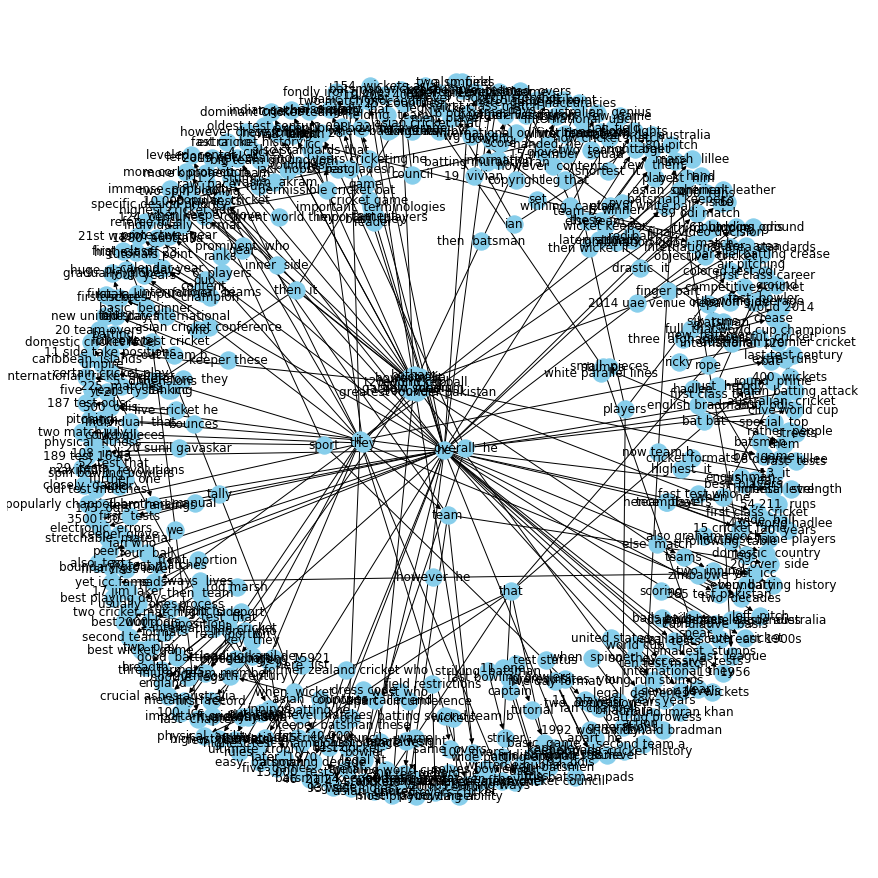

In [24]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Let us extract information from the knowledge graph

#### Q. Give us all entities that have "is" relationships?

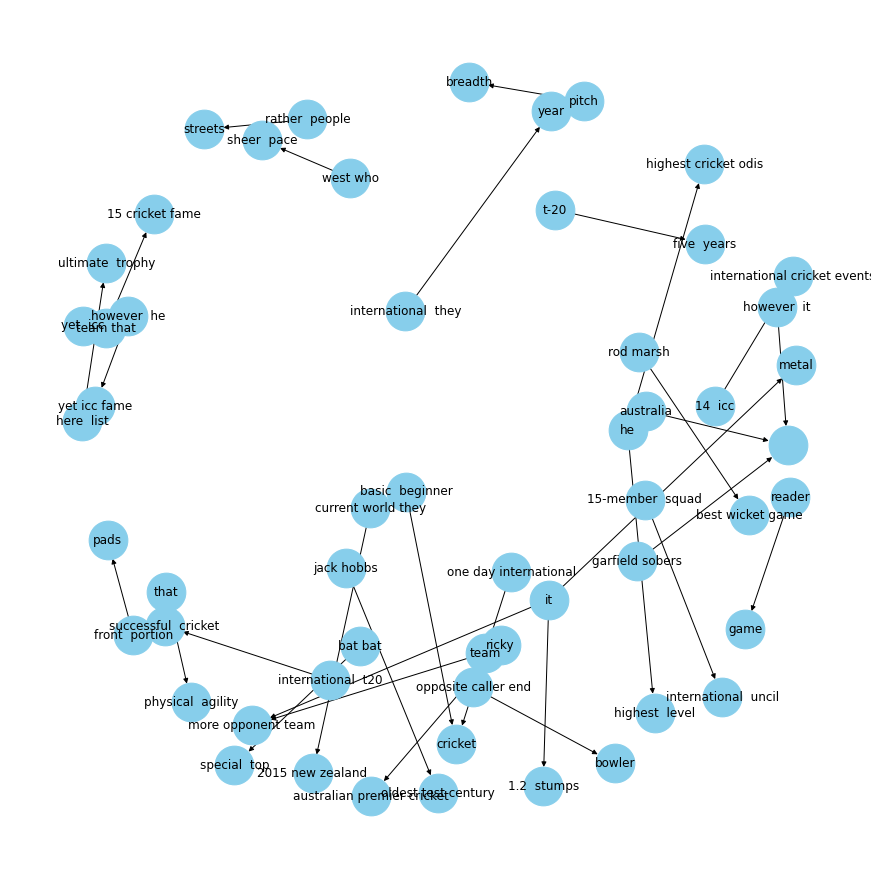

In [25]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == "is"], "source", "target", edge_attr=True, create_using = nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

#### Give us knowlege grapf for entities related to Lillee?

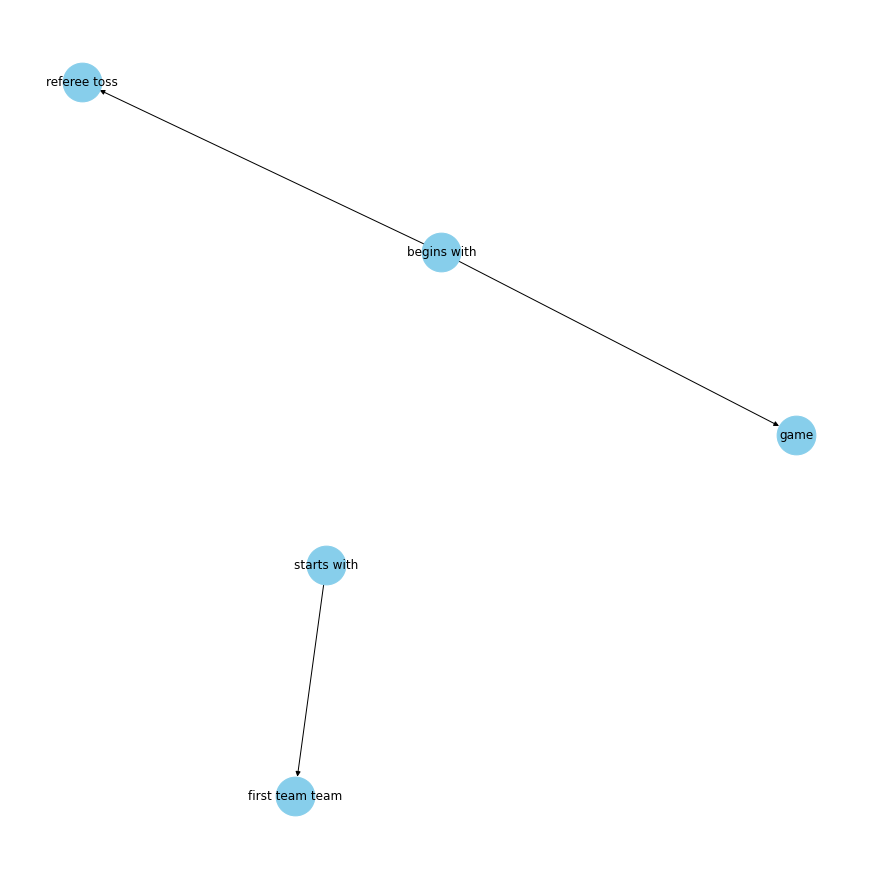

In [26]:
G = nx.from_pandas_edgelist(kg_df[kg_df['source'].str.contains("game")], "edge", "target", edge_attr=True, create_using = nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

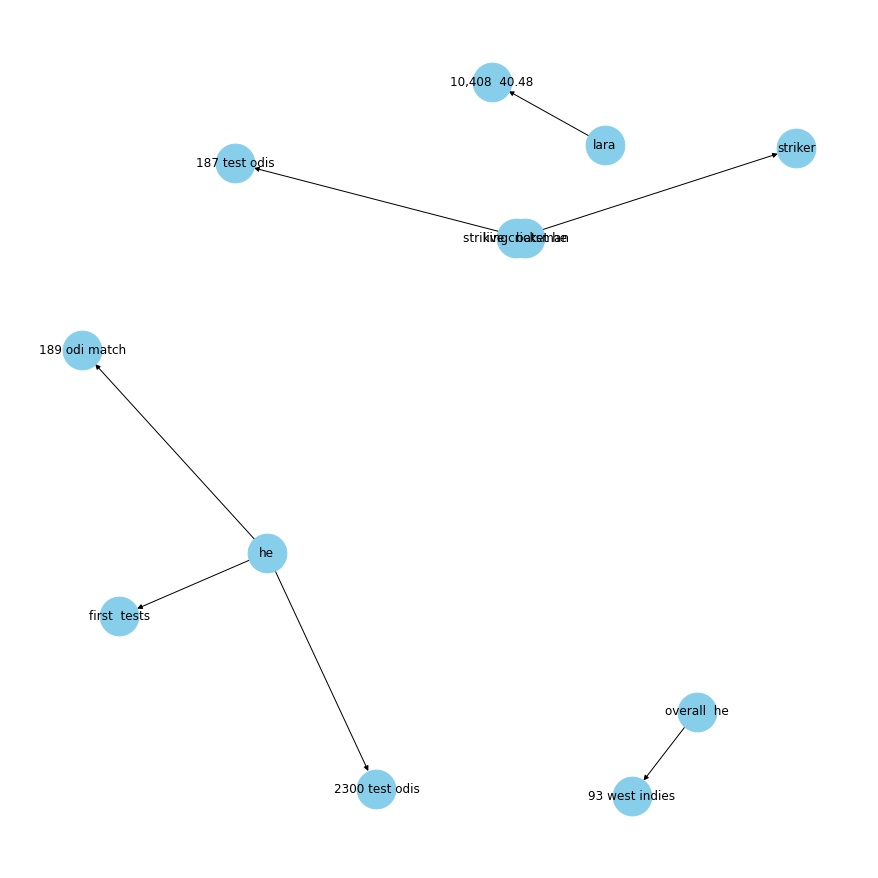

In [27]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="scored"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

#### Q.How many tests has Marshall played?

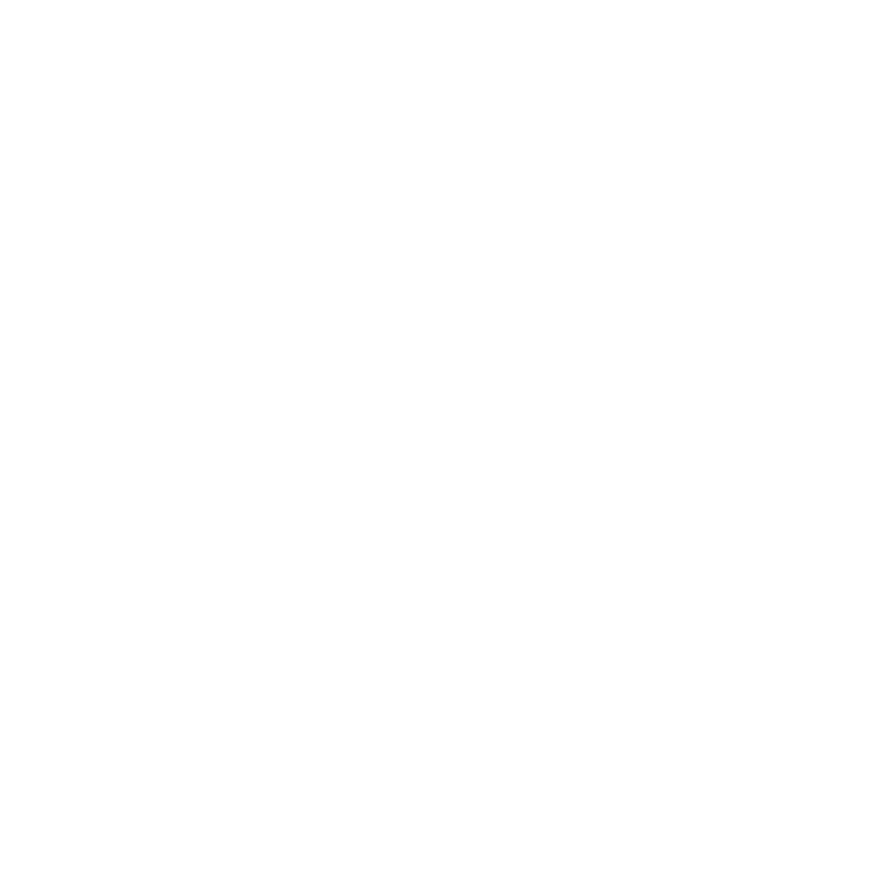

In [28]:
G = nx.from_pandas_edgelist(kg_df[(kg_df['source'].str.contains("marshall")) & (kg_df['edge'].str.contains("played"))], "target", edge_attr=True, create_using = nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

### Q. For how many years Lillee played professional cricket?

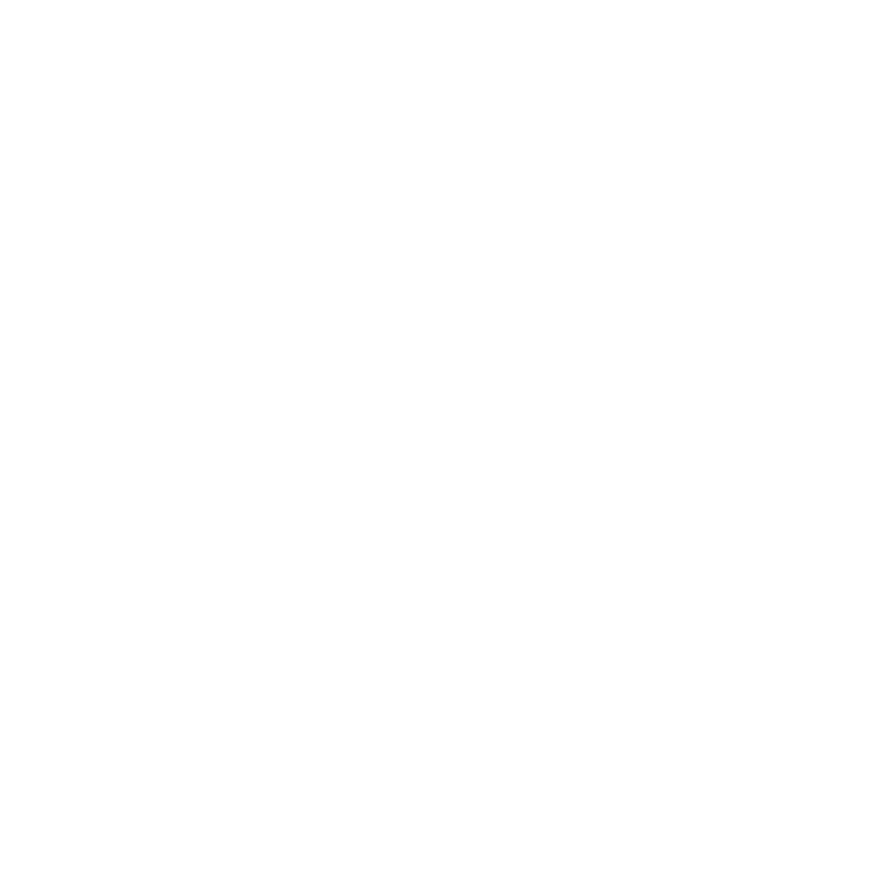

In [29]:
G = nx.from_pandas_edgelist(kg_df[(kg_df['source'].str.contains("lillee")) & (kg_df['edge'].str.contains("professional"))], "target", edge_attr=True, create_using = nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()